### Libraries setup

In [ ]:
#!pip3 install -r requirements.txt
!pip3 install torchinfo numpy pandas nibabel torchio tqdm matplotlib SimpleITK scikit-learn

In [ ]:
#!unzip znorm_cropped_imgs.zip -d /storage

### 3D U-Net testing

In [ ]:
from models.unet3d import UNet
from torchinfo import summary

samp_unet = UNet(1)
summary(samp_unet, (2,1,40,56,72))
#summary(samp_unet, (1,1,196,196,196))

### 3D U-Net Train + Test

In [ ]:
import torchio as tio

from models.unet3d import UNet
from model_utils.train_eval import train_model, hocv_train_model, start_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

firstUNet = UNet(1)
train_history = train_model(
    model=firstUNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    train_ids=train_subj,
    transforms=[tio.RandomNoise()],
    batch_size=2,
    num_epochs=100,
    learning_rate=0.0001
)

test_loss, test_met = start_eval(firstUNet, '/storage/znorm_cropped_imgs', 'L', test_subj, 2, True)

In [ ]:
import numpy as np
import datetime

np.savez('train_hist.npz', **train_history)
save_model(firstUNet)

### 3D U-Net hold-out cross validation

In [ ]:
import torchio as tio

from models.unet3d import UNet
from model_utils.train_eval import train_model, hocv_train_model, start_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

tr_train_subj, tr_val_subj = split_train_subjects('/storage/harp_metadata.csv', train_subj, 18, 42)

secondUNet = UNet(1)
train_val_hist = hocv_train_model(
    model = secondUNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    train_ids=tr_train_subj,
    val_ids=tr_val_subj,
    transforms=[tio.RandomNoise()],
    batch_size=2,
    num_epochs=200,
    learning_rate=0.00001
)

test_loss, test_met = start_eval(secondUNet, '/storage/znorm_cropped_imgs', 'L', test_subj, 2, True)

### 3D U-Net 5-fold Cross Validation for Number of Epochs

In [ ]:
import numpy as np
import torchio as tio

from models.unet3d import UNet
from model_utils.train_eval import train_model, hocv_train_model, skfcv_train_model, start_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

k_trainval_hist_50 = skfcv_train_model(
    model_class = UNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    meta_file='/storage/harp_metadata.csv',
    train_ids=train_subj,
    transforms=[
        tio.RandomNoise(),
        tio.OneOf({
            tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
        })
    ],
    batch_size=2,
    num_epochs=50,
    learning_rate=0.01,
    kfold=5,
    random_seed=42
)

np.savez('k_trainval_hist_50.npz', **k_trainval_hist_50)

In [ ]:
k_trainval_hist_100 = skfcv_train_model(
    model_class = UNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    meta_file='/storage/harp_metadata.csv',
    train_ids=train_subj,
    transforms=[
        tio.RandomNoise(),
        tio.OneOf({
            tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
        })
    ],
    batch_size=2,
    num_epochs=100,
    learning_rate=0.01,
    kfold=5,
    random_seed=42
)

np.savez('k_trainval_hist_100.npz', **k_trainval_hist_100)

In [ ]:
k_trainval_hist_150 = skfcv_train_model(
    model_class = UNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    meta_file='/storage/harp_metadata.csv',
    train_ids=train_subj,
    transforms=[
        tio.RandomNoise(),
        tio.OneOf({
            tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
        })
    ],
    batch_size=2,
    num_epochs=150,
    learning_rate=0.01,
    kfold=5,
    random_seed=42
)

np.savez('k_trainval_hist_150.npz', **k_trainval_hist_150)

In [ ]:
k_trainval_hist_200 = skfcv_train_model(
    model_class = UNet,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    meta_file='/storage/harp_metadata.csv',
    train_ids=train_subj,
    transforms=[
        tio.RandomNoise(),
        tio.OneOf({
            tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
        })
    ],
    batch_size=2,
    num_epochs=200,
    learning_rate=0.01,
    kfold=5,
    random_seed=42
)

np.savez('k_trainval_hist_200.npz', **k_trainval_hist_200)

In [ ]:
import numpy as np
import datetime

np.savez('train_val_hist2.npz', **train_val_hist)
save_model(secondUNet)

In [ ]:
import numpy as np
from model_utils.metrics import plot_per_epoch
train_val_hist = np.load('train_val_hist500.npz')
train_val_hist = dict(train_val_hist)

plot_per_epoch(train_val_hist, [('train_metric_per_epoch', 'train'), ('val_metric_per_epoch', 'validation')], 'Dice', 'Dice score during training')

/Users/shank/miniconda3/envs/dsa4199_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


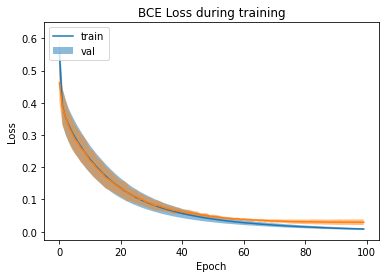

In [1]:
import numpy as np
from model_utils.metrics import plot_val_per_epoch

k_trainval_hist = np.load('k_trainval_hist.npz')
k_trainval_hist = dict(k_trainval_hist)

plot_val_per_epoch(k_trainval_hist,
                   [('train_loss_per_epoch', 'train'), ('val_loss_per_epoch', 'val')],
                  'Loss',
                  'BCE Loss during training')

### 2D U-Net Train

In [ ]:
import torchio as tio

from models.usegnet import SingleViewUSegNet
from model_utils.train_eval import train_2d_model, hocv_train_model, start_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

axial_net = SingleViewUSegNet()
train_history = train_2d_model(
    model=axial_net,
    view=0,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    train_ids=train_subj,
    batch_size=2,
    num_epochs=100,
    learning_rate=0.01
)

test_loss, test_met = start_2d_eval(axial_net, '/storage/znorm_cropped_imgs', 'L', test_subj, 2, True)

### 2D U-Net Holdout Cross Validation

In [ ]:
import torchio as tio

from models.usegnet import SingleViewUSegNet
from model_utils.train_eval import train_2d_model, hocv_train_2d_model, start_2d_eval, save_model
from data_utils.dataset import get_train_test_subjects, split_train_subjects

train_subj, test_subj = get_train_test_subjects(
    '/storage/harp_metadata.csv',
    '/storage/znorm_cropped_imgs',
    42,
    True
)

tr_train_subj, tr_val_subj = split_train_subjects('/storage/harp_metadata.csv', train_subj, 18, 42)

axial_net = SingleViewUSegNet()
train_val_hist = hocv_train_2d_model(
    model = axial_net,
    view=0,
    dir_name='/storage/znorm_cropped_imgs',
    brain_side='L',
    train_ids=tr_train_subj,
    val_ids=tr_val_subj,
    batch_size=2,
    num_epochs=100,
    learning_rate=0.01
)

test_loss, test_met = start_2d_eval(axial_net, 0, '/storage/znorm_cropped_imgs', 'L', test_subj, verbose=True)

### 2D U-Net 5-fold Cross Validation